# 1. Install Dependencies and Setup

In [ ]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
!pip list

Package                           Version
--------------------------------- ------------
absl-py                           2.1.0
aext_assistant                    0.4.0
aext_assistant_server             0.4.0
aext_core                         0.4.0
aext_core_server                  0.4.0
aext_shared                       0.4.0
aiobotocore                       2.7.0
aiofiles                          22.1.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
aiosqlite                         0.18.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-cli-base                 0.4.2
anaconda-client                   1.13.0
anaconda-cloud-auth               0.7.2
anaconda-navigator                2.6.4
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio                     

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting CPU Memory Consumption Growth
# Confirm you're running on CPU
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    print("No GPU found. Using CPU.")
else:
    print("GPU detected. Consider using set_memory_growth.")

# Optional: Check available devices
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

No GPU found. Using CPU.
Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [3]:
#tf.config.list_physical_devices('CPU')

# 2. Remove dodgy images

In [4]:
import cv2
from PIL import Image

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
def get_image_format(image_path):
    try:
        with Image.open(image_path) as img:
            return img.format.lower()
    except Exception:
        return None

for image_class in os.listdir(data_dir): 
    class_path = os.path.join(data_dir, image_class)
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        try: 
            img = cv2.imread(image_path)
            image_format = get_image_format(image_path)

            if image_format not in image_exts: 
                print(f'Image not in ext list: {image_path} ({image_format})')
                os.remove(image_path)
        except Exception as e: 
            print(f'Issue with image {image_path}: {e}')
            # os.remove(image_path)  # Uncomment to remove corrupted files

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 760 files belonging to 4 classes.


In [10]:
#tf.keras.utils.image_dataset_from_directory??

In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

In [13]:
#batch

In [14]:
len(batch)

2

In [15]:
batch[1]

array([2, 3, 0, 0, 0, 3, 1, 1, 3, 2, 0, 0, 2, 2, 0, 3, 0, 0, 2, 0, 0, 1,
       1, 0, 0, 0, 3, 2, 1, 3, 0, 0])

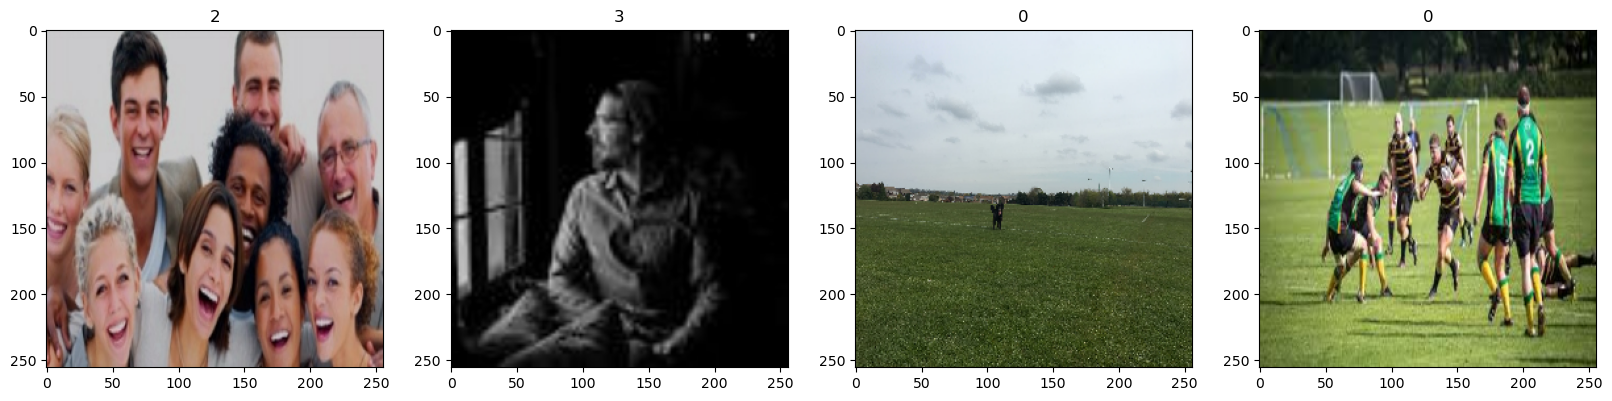

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [18]:
scale_iterator = data.as_numpy_iterator()

In [19]:
batch = scale_iterator.next()

In [20]:
len(data)

24

In [21]:
batch[0].shape

(32, 256, 256, 3)

In [23]:
batch[0].max()

1.0

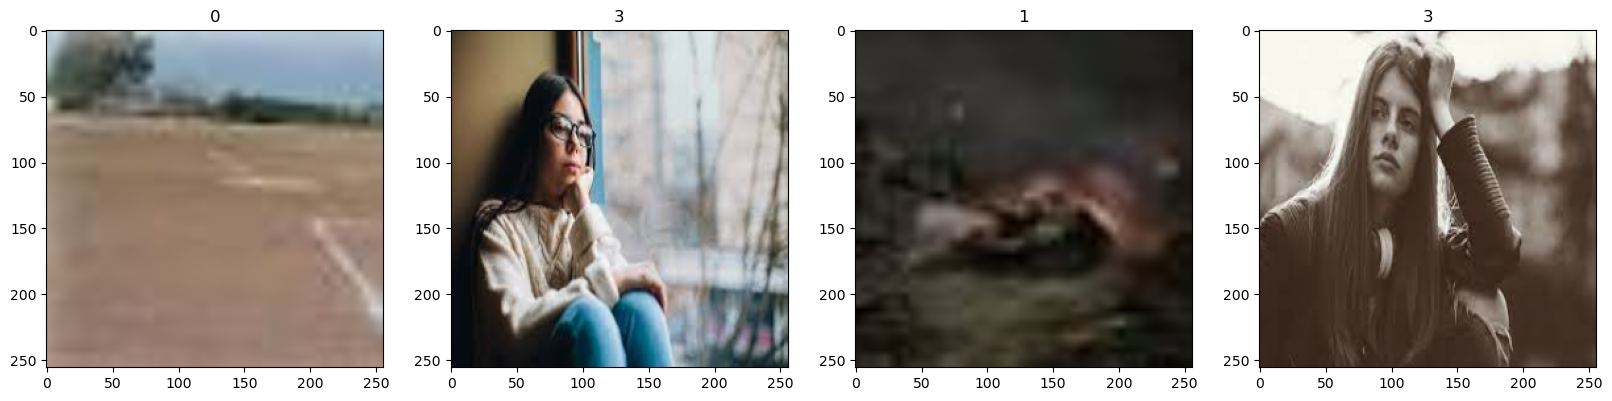

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 5. Split Data

In [25]:
total_size = len(data)
train_size = int(total_size * 0.7)
test_size = int(total_size * 0.15)
val_size = total_size - train_size - test_size  # assign the leftover to validation

In [26]:
train_size

16

In [27]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [28]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [32]:
model = Sequential([
    Input(shape=(256, 256, 3)),  # Correct way to define input shape
    Conv2D(16, (3,3), strides=1, activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), strides=1, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3,3), strides=1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')  # For 4-class classification
])

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

# 7. Train

In [36]:
logdir='logs'

In [37]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [38]:
clas_train = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


16/16 [==============================] - 29s 1s/step - loss: 1.6025 - accuracy: 0.3555 - val_loss: 1.0455 - val_accuracy: 0.5000
Epoch 2/20
16/16 [==============================] - 22s 1s/step - loss: 1.0577 - accuracy: 0.5273 - val_loss: 0.9354 - val_accuracy: 0.5375
Epoch 3/20
16/16 [==============================] - 24s 1s/step - loss: 0.8098 - accuracy: 0.6621 - val_loss: 0.6387 - val_accuracy: 0.7625
Epoch 4/20
16/16 [==============================] - 22s 1s/step - loss: 0.6149 - accuracy: 0.7930 - val_loss: 0.6934 - val_accuracy: 0.7563
Epoch 5/20
16/16 [==============================] - 24s 1s/step - loss: 0.5511 - accuracy: 0.8281 - val_loss: 0.5028 - val_accuracy: 0.7937
Epoch 6/20
16/16 [==============================] - 23s 1s/step - loss: 0.3539 - accuracy: 0.8848 - val_loss: 0.3339 - val_accuracy: 0.8813
Epoch 7/20
16/16 [==============================] - 24s 1s/step - loss: 0.2410 - accuracy: 0.9121 - val_loss: 0.1860 - val_accuracy: 0.9438
Epoch 8/20
16/16 [

# 8. Plot Performance

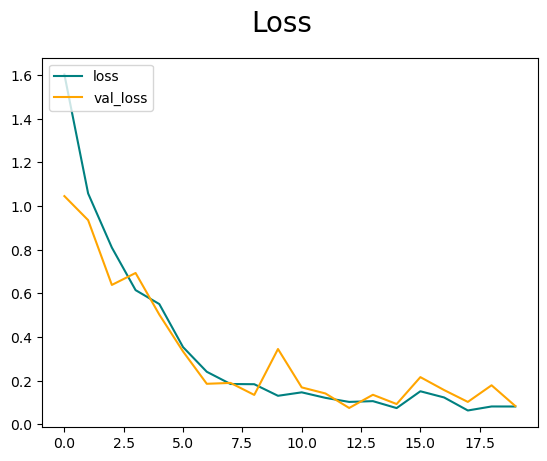

In [39]:
fig = plt.figure()
plt.plot(clas_train.history['loss'], color='teal', label='loss')
plt.plot(clas_train.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

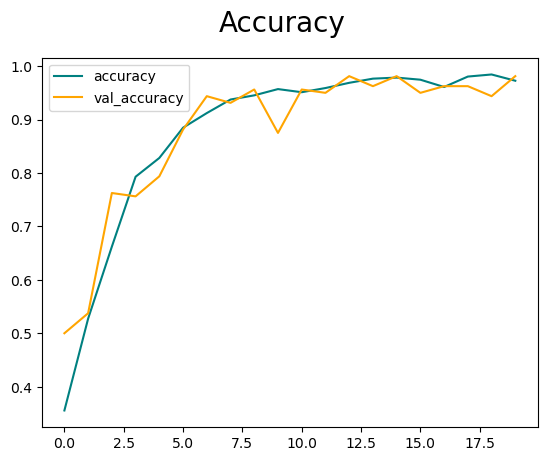

In [40]:
fig = plt.figure()
plt.plot(clas_train.history['accuracy'], color='teal', label='accuracy')
plt.plot(clas_train.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [41]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [42]:
X, y = batch

In [43]:
# Get model prediction
y_pred = model.predict(X)

# Convert predictions from probabilities to class indices
y_pred_classes = tf.argmax(y_pred, axis=1)  # shape: [batch_size]
y_true_classes = tf.argmax(y, axis=1) if len(y.shape) == 2 else y  # depends on label format

1/1 [==============================] - 0s 425ms/step


In [44]:
# Metrics
pre = tf.keras.metrics.Precision()
re = tf.keras.metrics.Recall()
acc = tf.keras.metrics.SparseCategoricalAccuracy()

# Update metrics
pre.update_state(y_true_classes, y_pred_classes)
re.update_state(y_true_classes, y_pred_classes)
acc.update_state(y_true_classes, y_pred)

# View results
print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Accuracy:", acc.result().numpy())

Precision: 1.0
Recall: 1.0
Accuracy: 1.0


In [45]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [46]:
import cv2

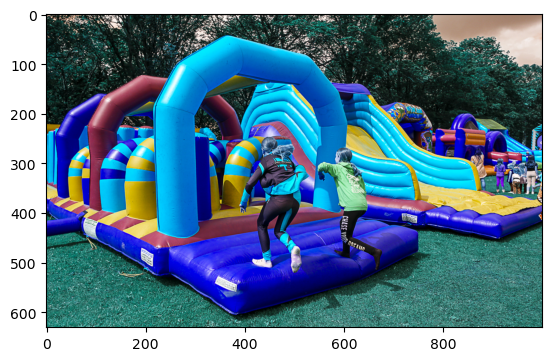

In [47]:
img = cv2.imread('test2.jpg')
plt.imshow(img)
plt.show()

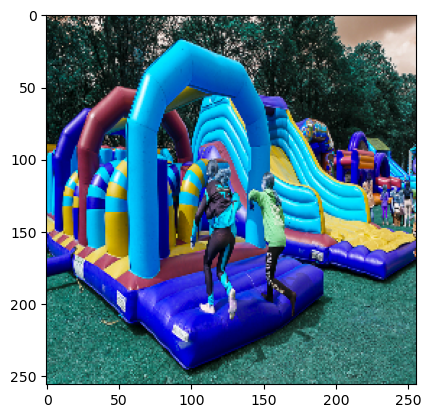

In [48]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [49]:
y_pr = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 257ms/step


In [50]:
# Define class labels in order
class_names = ['playground', 'war ground', 'happy', 'sad']

In [51]:
# Get index of highest probability
predicted_index = np.argmax(y_pr)

In [52]:
# Get class name
predicted_class = class_names[predicted_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {y_pr[0][predicted_index]:.4f}")

Predicted class: playground
Confidence: 0.6554


# 11. Save the Model

In [53]:
from tensorflow.keras.models import load_model

In [56]:
model.save(os.path.join('models', 'Emotion_imgclassifier.keras'))

In [60]:
# Load your .keras model
model = load_model("models/Emotion_imgclassifier.keras")

# Save as .h5
model.save("Emotion_imgclassifier.h5")

In [62]:
#my_model.predict(np.expand_dims(resize/255, 0))

In [61]:
#import os
#print(os.listdir())